Final Presentation



Weighted KNN Component

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.neighbors import KNeighborsRegressor    
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import os
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import tensorflow as tf
import math
from sklearn.datasets import make_blobs # split a dataset into train and test sets
import os
import shutil
import csv
import sys

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Helper Functions
def distanceError (actual, predicted):
    distance = 0
    for pos in range(2):
        distance += (actual[pos] - predicted[pos]) ** 2
    return math.sqrt(distance)

def concat_N_PowerMaps (file_path,file_names):
    first = True
    for fname in file_names:
        file_full = "/".join([file_path,fname])
        if os.path.isfile(file_full):
            if first:
                data = pd.read_csv(file_full) 
                array = data.values
                powerMaps = np.array(array[:,:3])
                first = False
            else:
                data = pd.read_csv(file_full) 
                array = data.values
                toAddColumn = np.array(array[:,2])
                powerMaps = np.c_[powerMaps, toAddColumn]
        else:
            print("Unable to identify file " + fname + " in file path " + file_path)
    return powerMaps

def extractRSSI_values(receiver_loc, path, filenames):
    rssiFromTrans = []
    for file in filenames:
        map = pd.read_csv(path+'/'+file)
        map = torch.Tensor(map.to_numpy())
        map = map[:,:3]

        idx = set(list(np.where(map[:,0] == receiver_loc[0])[0]))
        idx &= set(list(np.where(map[:,1] == receiver_loc[1])[0]))
        idx = list(idx)[0]

        rssiFromTrans.append(map[idx,2].item())

    return rssiFromTrans

def predictedPlot (data, file_path, file_names, knnr):
    #Convert location to Power Value
    predictions = [[1,1]]
    for pos in data:
        powerValue = extractRSSI_values(pos, file_path, file_names)
        prediction = knnr.predict([powerValue])
        predictions = np.append(predictions, prediction, axis=0) 
    predictions = np.delete(predictions, 0, 0) #Delete the initial value of [1,1,1] added
    return predictions

#Localization Algorithm
def get_trainedKNNR (folder_path, file_names, N_value = 5):
    data = concat_N_PowerMaps(folder_path, file_names)
    input = data[:,2:] #All the RSSI values from each transmitter
    output = data [:,:2] #Output the X and Y coordinates. Disregard the Z coordinate
    knnr = KNeighborsRegressor(n_neighbors = N_value)
    knnr.fit(input, output)
    return knnr

#Calculate Error
def distanceError (actual, predicted):
    distance = 0
    for pos in range(2):
        distance += (actual[pos] - predicted[pos]) ** 2
    return math.sqrt(distance)

def error_calculator (actual, predicted):
    error = 0
    for pos in range(len(actual)):
        error += distanceError(actual[pos], predicted[pos])
    return error/(len(actual)*10)
    

Defining Model, and loading saved parameters

In [ ]:
# CNN architecture
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(14 * 19 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

        
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 14 * 19 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 14, 19))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
encoder = Encoder(encoded_space_dim=4,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4,fc2_input_dim=128)

In [ ]:
encoder.load_state_dict(torch.load('/content/drive/MyDrive/ECE496 Capstone Project/Saved Model/encoder_weights'))

<All keys matched successfully>

In [ ]:
decoder.load_state_dict(torch.load('/content/drive/MyDrive/ECE496 Capstone Project/Saved Model/decoder_weights'))

<All keys matched successfully>

Importing Data

In [ ]:
# Normalize the rssi values for each map
def data_normalize(x, rssi_min, rssi_max):
  return (x-rssi_min)/(rssi_max-rssi_min)
# Normalizing the RSSI values for the sets

def normalize_set(data, rssi_min, rssi_max):
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
          cur_rssi =  data[i][j][2]
          if cur_rssi < rssi_min:
              data[i][j][2] = rssi_min
          data[i][j][2] = data_normalize(cur_rssi, rssi_min, rssi_max)
  return data

def save_final_output_maps(rssi_maps, location):
  directory = os.path.join(hi_fi_folder)
  folder_path = hi_fi_folder
  dir = os.listdir(folder_path)
  for x in dir:
    df_transform = pd.read_csv(hi_fi_folder+ '/'+x)
    df_transform.to_csv((location + "/ml_output_" +x),index=False)
    
def get_transmitter(filename):
    filename = filename.split('.')[0]
    trans = filename.split('_')[1:]

    for i in range(3):
        trans[i] = trans[i].replace('x','')
        trans[i] = trans[i].replace('y','')
        trans[i] = trans[i].replace('z','')
        trans[i] = trans[i].replace('n','-')
        trans[i] = trans[i].replace('p','.')
        trans[i] = float(trans[i])

    return trans

def rec_trans_p2p(rec,trans):
    return round(math.sqrt( ((rec[0]-trans[0])**2) + ((rec[1]-trans[1])**2) ),2)

def friisFormula(rec,trans):
    R = rec_trans_p2p(rec,trans)
    friis = 15 + 3 + 2.15 + 20*math.log10(0.1391148297/(4*math.pi*R))
    return round(friis,2)
  
def addEnvData(map, trans_loc):
    dist = []
    friis = []
    LoS = []

    for i in range(len(map)):
        rec_loc = [map[i,0].item(),map[i,1].item()]
        dist.append(rec_trans_p2p(rec_loc,trans_loc))
        friis_val = friisFormula(rec_loc,trans_loc)
        friis.append(friis_val)

        if abs(friis_val-map[i,2].item()) < 5:
            LoS.append(1)
        else:
            LoS.append(0)
    
    dist = np.array(dist)[np.newaxis].T
    friis = np.array(friis)[np.newaxis].T
    LoS = np.array(LoS)[np.newaxis].T

    return np.concatenate((map,dist,friis,LoS),axis=1)


In [ ]:
low_fi_folder="/content/drive/MyDrive/ECE496 Capstone Project/Final Presentation/initialRSSIMap"
hi_fi_folder="/content/drive/MyDrive/ECE496 Capstone Project/Final Presentation/selectedMaps"

num_files=len([name for name in os.listdir(low_fi_folder) if os.path.isfile(os.path.join(low_fi_folder, name))])
data_list_low_fi=[]
data_list_high_fi=[]
general_to_name_low={}
general_to_name_high={}

In [ ]:
for filename in os.listdir(low_fi_folder):
    general_to_name_low[filename[5:]]=filename

for filename in os.listdir(hi_fi_folder):
    general_to_name_high[filename[5:]]=filename

In [ ]:

for filename in os.listdir(hi_fi_folder):
  if filename[5:] in general_to_name_low:
    file_location_low=os.path.join(low_fi_folder, general_to_name_low[filename[5:]])
    curr_low_fi_map=np.loadtxt(file_location_low,skiprows=1,dtype=np.float64,delimiter=',',usecols=(0,1,3))
    tran_loc=get_transmitter(general_to_name_low[filename[5:]])
    new_low_fi_map = addEnvData(curr_low_fi_map,tran_loc)
    data_list_low_fi.append(curr_low_fi_map)
    file_location_high=os.path.join(hi_fi_folder, filename)
    data_list_high_fi.append(np.loadtxt(file_location_high,skiprows=1,dtype=np.float64,delimiter=',',usecols=(0,1,3)))
  else:
    print(filename+ " has no corresponding low fi map")

In [38]:
# hifi_CSV_folder = "/content/drive/MyDrive/ECE496 Capstone Project/Final Presentation/selectedMaps"
# hifi_maps_2 = os.listdir(hifi_CSV_folder)[:2]
# n_value = 5 #Default is five
# print(hifi_maps_2)
# KNNR_model = get_trainedKNNR(hifi_CSV_folder, hifi_maps_2, n_value)

# #Accuracy across a line
# line_path = "/content/drive/MyDrive/ECE496 Capstone Project/kNN Algorithm/kNNTestPoints.csv"
# map = pd.read_csv(line_path)
# actual_Value = map.values
# estimated_Value = predictedPlot(actual_Value, hifi_CSV_folder, hifi_maps_2, KNNR_model)
# print(error_calculator(actual_Value, estimated_Value))



['hifi_x18p7125_yn10p0309_z2p75.csv', 'hifi_x11p7125_yn10p5309_z2p75.csv']
2.229537702959274


In [ ]:
low_fi_data=np.stack(data_list_low_fi)
high_fi_data=np.stack(data_list_high_fi)
unique_vals_x=np.unique(low_fi_data[0,:,0])
unique_vals_y=np.unique(low_fi_data[0,:,1])
rssi_lmin = np.min(low_fi_data[0,:,2])
rssi_lmax = np.max(low_fi_data[0,:,2])
rssi_hmin = np.min(high_fi_data[0,:,2])
rssi_hmax = np.max(high_fi_data[0,:,2])
low_fi_data = normalize_set(low_fi_data, rssi_lmin, rssi_lmax)
high_fi_data = normalize_set(high_fi_data, rssi_hmin, rssi_hmax)

In [ ]:
# Do this for all maps in hifi data
length = len(high_fi_data)
hifi_data = []
for i in range(length):
  x_y_pairs={}
  for row in high_fi_data[i]:
    x_y_pairs[(row[0],row[1])]=row[2]
  map=np.full((120,155), -1,dtype=np.float64)
  for i,val_x in enumerate(unique_vals_x):
    for j,val_y in enumerate(unique_vals_y):
      if (val_x,val_y) in x_y_pairs:
        map[i][j]=x_y_pairs[(val_x,val_y)]
  hifi_data.append(map)

# Do this for all maps in lofi data
length = len(low_fi_data)
lofi_data = []
for i in range(length):
  x_y_pairs={}
  for row in low_fi_data[i]:
    x_y_pairs[(row[0],row[1])]=row[2]
  map=np.full((120,155), -1,dtype=np.float64)
  for i,val_x in enumerate(unique_vals_x):
    for j,val_y in enumerate(unique_vals_y):
      if (val_x,val_y) in x_y_pairs:
        map[i][j]=x_y_pairs[(val_x,val_y)]
  lofi_data.append(torch.Tensor(np.expand_dims(map,axis=(0,1))))

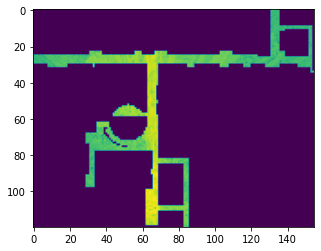

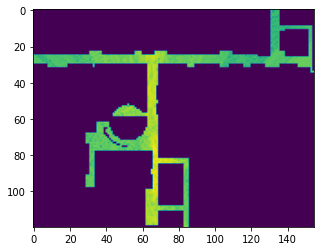

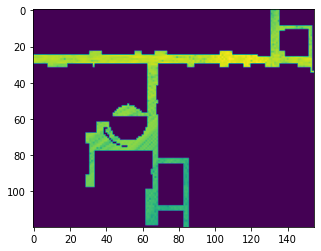

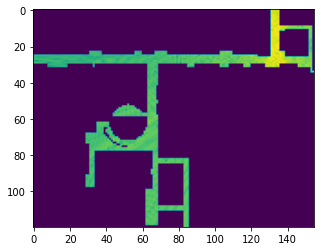

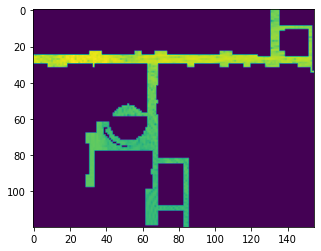

In [ ]:
for img in hifi_data:
  plt.imshow(img)
  plt.show()

In [ ]:
def run_inference_save_outputs(encoder,decoder,data):
  model_output_maps=[]
  for map in data:
    encoded_input=encoder(map)
    decoded_output=decoder(encoded_input)
    model_output_maps.append(decoded_output)

  save_final_output_maps(model_output_maps,"/content/drive/MyDrive/ECE496 Capstone Project/Final Presentation/Model output")


In [ ]:
run_inference_save_outputs(encoder,decoder,lofi_data)
print("Completed")